In [1]:
import os
from PIL import Image
import numpy as np
from keras.layers import Input, Convolution2D, merge, Dense, Dropout, Flatten, Conv2D, MaxPooling3D
from keras.models import Model, Sequential
from keras.callbacks import LearningRateScheduler
from keras import backend as K
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import h5py
import math
from skimage.io import imread
from matplotlib import pyplot as plt
import sklearn.feature_extraction
import sklearn.feature_selection as t
from keras.utils import np_utils
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim
import scipy.ndimage.filters
import random

Using TensorFlow backend.


In [2]:
def PSNR(y_true, y_pred):
    return 10.0 * K.log(1 / (K.mean(K.square(y_pred - y_true)))) / K.log(10.0)

In [3]:
def threecompare(in_im, out_im, pred_im):
    img1 = (out_im*255).reshape(img_rows, img_cols)
    img2 = (in_im*255).reshape(img_rows, img_cols)
    kernel = np.ones((3,3))*(-1)
    kernel[1,1] = 8
    lap = scipy.ndimage.filters.convolve((in_im*255).reshape(img_rows, img_cols), kernel)
    laps = lap*100.0/np.amax(lap)
    img3 = ((in_im*255).reshape(img_rows, img_cols) + laps/10).reshape(img_rows, img_cols)
    img4 = (pred_im*255).reshape(img_rows, img_cols)
    label = 'SSIM: {:.2f}'
    ssim1 = ssim(img1, img1, data_range=img1.max() - img1.min())
    ssim2 = ssim(img1, img2, data_range=img2.max() - img2.min())
    ssim3 = ssim(img1, img3, data_range=img3.max() - img3.min())
    ssim4 = ssim(img1, img4, data_range=img4.max() - img4.min())
    print('Original image')
    print(label.format(ssim1))
    print('\n'+'Bicubic image')
    print(label.format(ssim2))
    print('\n'+'Bicubic with laplasian image')
    print(label.format(ssim3))
    print('\n'+'Produced image')
    print(label.format(ssim4))

In [4]:
def imload(d, mode, channels, img_rows, img_cols):
    directory = '../Картинки/'+d
    files = os.listdir(directory)
    flag = True
    i = 0
    while flag and i < len(files):
        if files[i] == '.DS_Store':
            del files[i]
            flag = False
        i+= 1
    num = 0
    for name in range(len(files)):
        im = Image.open(directory+'/'+ files[name]).convert('L')
        width, height = im.size
        num += (width//img_rows)*(height//img_cols)
    num = num*4
    x = np.zeros((num, img_rows, img_cols, channels))
    y = np.zeros((num, img_rows, img_cols, channels))
    num1 = np.zeros((num))
    num = 0
    for name in range(len(files)):
        I = Image.open(directory+'/'+ files[name]).convert('L')
        width1, height1 = I.size
        if (width1//img_rows > 1) and (height1//img_cols > 1):
            for i in range(width1//img_rows):
                for j in range(height1//img_cols):
                    im = I.crop((i*img_rows, j*img_cols, (i+1)*img_rows, (j+1)*img_cols))
                    width, height = im.size
                    for k in range(4):
                        im_ = im.rotate(90*k)
                        a = np.asarray(im_).astype('float32')
                        im1 = im_.resize((int(width/2), int(height/2)))
                        im1 = im1.resize((width, height), Image.BICUBIC)
                        a1 = np.asarray(im1).astype('float32')
                        a = a.reshape(img_rows, img_cols, channels)
                        a1 = a1.reshape(img_rows, img_cols, channels)
                        flag = True
                        while flag:
                            e = random.randint(0, len(num1)-1)
                            if num1[e] != 1:
                                flag = False
                        num1[e] = 1
                        x[e] = a1
                        y[e] = a
        elif width1//img_rows > 1:
            for i in range(width1//img_rows):
                im = I.crop((i*img_rows, 0, (i+1)*img_rows, img_cols))
                width, height = im.size
                for k in range(4):
                    im_ = im.rotate(90*k)
                    a = np.asarray(im_).astype('float32')
                    im1 = im_.resize((int(width/2), int(height/2)))
                    im1 = im1.resize((width, height), Image.BICUBIC)
                    a1 = np.asarray(im1).astype('float32')
                    a = a.reshape(img_rows, img_cols, channels)
                    a1 = a1.reshape(img_rows, img_cols, channels)
                    flag = True
                    while flag:
                        e = random.randint(0, len(num1)-1)
                        if num1[e] != 1:
                            flag = False
                    num1[e] = 1
                    x[num] = a1
                    y[num] = a
                    num += 1
        elif height1//img_cols > 1:
            for j in range(height1//img_cols):
                im = I.crop((0, j*img_cols, img_rows, (j+1)*img_cols))
                width, height = im.size
                for k in range(4):
                    im_ = im.rotate(90*k)
                    a = np.asarray(im_).astype('float32')
                    im1 = im_.resize((int(width/2), int(height/2)))
                    im1 = im1.resize((width, height), Image.BICUBIC)
                    a1 = np.asarray(im1).astype('float32')
                    a = a.reshape(img_rows, img_cols, channels)
                    a1 = a1.reshape(img_rows, img_cols, channels)
                    flag = True
                    while flag:
                        e = random.randint(0, len(num1)-1)
                        if num1[e] != 1:
                            flag = False
                    num1[e] = 1
                    x[num] = a1
                    y[num] = a
                    num += 1
        else:
            im = I.crop((0,0,img_rows, img_cols))
            width, height = im.size
            for k in range(4):
                im_ = im.rotate(90*k)
                a = np.asarray(im_).astype('float32')
                im1 = im_.resize((int(width/2), int(height/2)))
                im1 = im1.resize((width, height), Image.BICUBIC)
                a1 = np.asarray(im1).astype('float32')
                a = a.reshape(img_rows, img_cols, channels)
                a1 = a1.reshape(img_rows, img_cols, channels)
                flag = True
                while flag:
                    e = random.randint(0, len(num1)-1)
                    if num1[e] != 1:
                        flag = False
                num1[e] = 1
                x[num] = a1
                y[num] = a
                num += 1
    return x, y

In [5]:
def preprocess(x, y, channels, img_rows, img_cols):
    x /= 255
    y /= 255
    x = x.astype('float32')
    y = y.astype('float32')
    x = x.reshape(x.shape[0], img_rows, img_cols, channels)
    y = y.reshape(y.shape[0], img_rows, img_cols, channels)
    return x, y

In [6]:
def getim(im):
    im1 = Image.new('L', (im.shape[0],im.shape[1]))
    p = im1.load()
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if int(im[i][j]) > 255:
                p[i,j] = 255
            elif int(im[i][j]) < 0:
                p[i,j] = 0
            else:
                p[i,j] = int(im[i][j])
    return im1

In [47]:
def results(x, y, p, img_rows, img_cols, f):
    PSNR_bicubic = 0
    PSNR_laplasian = 0
    PSNR_model = 0
    for i in range(len(x)):
        im1 = x[i]*255
        kernel = np.ones((3,3))*(-1)
        kernel[1,1] = 8
        lap = scipy.ndimage.filters.convolve(im1.reshape(img_rows, img_cols), kernel)
        laps = lap*100.0/np.amax(lap)
        im2 = y[i]*255
        im3 = p[i]*255
        im4 = (im1.reshape(img_rows, img_cols) + laps/10)
        answer1 = getim(im1)
        answer1.save('model 2-3/original/'+f+'/image '+str(i)+' bicubic.png','png')
        answer2 = getim(im2)
        answer2.save('model 2-3/original/'+f+'/image '+str(i)+' original.png','png')
        answer3 = getim(im3)
        answer3.save('model 2-3/original/'+f+'/image '+str(i)+' worked.png','png')
        answer4 = getim(im4)
        answer4.save('model 2-3/original/'+f+'/image '+str(i)+' with laplasian.png','png')
        PSNR_bicubic += 10.0 * np.log(255*255 / (np.mean(np.square(im1.reshape(img_rows, img_cols) - im2.reshape(img_rows, img_cols))))) / np.log(10.0)
        PSNR_laplasian += 10.0 * np.log(255*255 / (np.mean(np.square(im4.reshape(img_rows, img_cols) - im2.reshape(img_rows, img_cols))))) / np.log(10.0)
        PSNR_model += 10.0 * np.log(255*255 / (np.mean(np.square(im3.reshape(img_rows, img_cols) - im2.reshape(img_rows, img_cols))))) / np.log(10.0)    
    print('Bicubic PSNR:', PSNR_bicubic/len(x))
    print('Laplasian PSNR:', PSNR_laplasian/len(x))
    print('Model PSNR:', PSNR_model/len(x))

In [8]:
def ressim(x, y, p, img_rows, img_cols):
    SSIM_bicubic = 0
    SSIM_laplasian = 0
    SSIM_model = 0
    for i in range(len(x)):
        im1 = x[i]*255
        kernel = np.ones((3,3))*(-1)
        kernel[1,1] = 8
        lap = scipy.ndimage.filters.convolve(im1.reshape(img_rows, img_cols), kernel)
        laps = lap*100.0/np.amax(lap)
        im4 = (im1.reshape(img_rows, img_cols) + laps/10)
        im2 = y[i]*255
        im3 = p[i]*255
        SSIM_bicubic += ssim(im1.reshape(img_rows, img_cols), im2.reshape(img_rows, img_cols), data_range=im1.reshape(img_rows, img_cols).max() - im2.reshape(img_rows, img_cols).min())
        SSIM_laplasian += ssim(im4.reshape(img_rows, img_cols), im2.reshape(img_rows, img_cols), data_range=im4.reshape(img_rows, img_cols).max() - im2.reshape(img_rows, img_cols).min())
        SSIM_model += ssim(im3.reshape(img_rows, img_cols), im2.reshape(img_rows, img_cols), data_range=im3.reshape(img_rows, img_cols).max() - im2.reshape(img_rows, img_cols).min())
    print('Bicubic SSIM:', SSIM_bicubic/len(x))
    print('Laplasian SSIM:', SSIM_laplasian/len(x))
    print('Model SSIM:', SSIM_model/len(x))

In [9]:
img_rows, img_cols = 100, 100
mode = 'L'
channels = 1

In [10]:
batch_size = 15
nb_epoch = 500
n1 = 10
f1 = 15
n2 = 1
f2 = 1

In [11]:
X_train, Y_train = imload('Train/Train_first', mode, channels, img_rows, img_cols)
X_test, Y_test = imload('Test/Test_first', mode, channels, img_rows, img_cols)
X_test5, Y_test5 = imload('Test/Set5', mode, channels, img_rows, img_cols)
X_test14, Y_test14 = imload('Test/Set14', mode, channels, img_rows, img_cols)
X_valid, Y_valid = imload('Validation/Validation_first', mode, channels, img_rows, img_cols)

In [12]:
in_train, out_train = preprocess(X_train, Y_train, channels, img_rows, img_cols)
in_test, out_test = preprocess(X_test, Y_test, channels, img_rows, img_cols)
in_test5, out_test5 = preprocess(X_test5, Y_test5, channels, img_rows, img_cols)
in_test14, out_test14 = preprocess(X_test14, Y_test14, channels, img_rows, img_cols)
in_valid, out_valid = preprocess(X_valid, Y_valid, channels, img_rows, img_cols)

In [13]:
input_shape = (img_rows, img_cols, channels)
model = Sequential()
model.add(Conv2D(n1, (f1, f1), input_shape=input_shape, activation='relu', name='filters', padding="same")) #активацию убать
model.add(Conv2D(n2, (f2, f2), padding="same", name='output'))
model.compile(loss="mse", optimizer="adam", metrics=[PSNR])

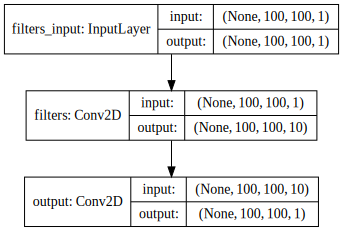

In [14]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [15]:
history = model.fit(in_train, out_train, batch_size=batch_size, epochs=nb_epoch,
          verbose=1, validation_data=(in_valid, out_valid))

Train on 1224 samples, validate on 176 samples
Epoch 1/500
1224/1224 [==============================] - 29s 24ms/step - loss: 0.0154 - PSNR: 19.5564 - val_loss: 0.0085 - val_PSNR: 21.4695
Epoch 2/500
1224/1224 [==============================] - 31s 25ms/step - loss: 0.0050 - PSNR: 23.1258 - val_loss: 0.0050 - val_PSNR: 23.6579
Epoch 3/500
1224/1224 [==============================] - 35s 29ms/step - loss: 0.0037 - PSNR: 24.4443 - val_loss: 0.0039 - val_PSNR: 24.6526
Epoch 4/500
1224/1224 [==============================] - 33s 27ms/step - loss: 0.0031 - PSNR: 25.2648 - val_loss: 0.0032 - val_PSNR: 25.5728
Epoch 5/500
1224/1224 [==============================] - 29s 24ms/step - loss: 0.0025 - PSNR: 26.2422 - val_loss: 0.0025 - val_PSNR: 26.5843
Epoch 6/500
1224/1224 [==============================] - 30s 25ms/step - loss: 0.0021 - PSNR: 26.9850 - val_loss: 0.0021 - val_PSNR: 27.2470
Epoch 7/500
1224/1224 [==============================] - 28s 23ms/step - loss: 0.0020 - PSNR: 27.3193 - val

1224/1224 [==============================] - 65s 53ms/step - loss: 0.0013 - PSNR: 29.2108 - val_loss: 0.0013 - val_PSNR: 29.2326
Epoch 59/500
1224/1224 [==============================] - 64s 53ms/step - loss: 0.0013 - PSNR: 29.1831 - val_loss: 0.0014 - val_PSNR: 29.0895
Epoch 60/500
1224/1224 [==============================] - 78s 64ms/step - loss: 0.0013 - PSNR: 29.2555 - val_loss: 0.0013 - val_PSNR: 29.2448
Epoch 61/500
1224/1224 [==============================] - 73s 60ms/step - loss: 0.0013 - PSNR: 29.1985 - val_loss: 0.0013 - val_PSNR: 29.2141
Epoch 62/500
1224/1224 [==============================] - 78s 64ms/step - loss: 0.0013 - PSNR: 29.1232 - val_loss: 0.0013 - val_PSNR: 29.1685
Epoch 63/500
1224/1224 [==============================] - 70s 57ms/step - loss: 0.0013 - PSNR: 29.2071 - val_loss: 0.0016 - val_PSNR: 28.1993
Epoch 64/500
1224/1224 [==============================] - 77s 63ms/step - loss: 0.0013 - PSNR: 29.2258 - val_loss: 0.0013 - val_PSNR: 29.2634
Epoch 65/500
1224/1

1224/1224 [==============================] - 44s 36ms/step - loss: 0.0018 - PSNR: 28.1143 - val_loss: 0.0013 - val_PSNR: 29.4134
Epoch 116/500
1224/1224 [==============================] - 42s 35ms/step - loss: 0.0012 - PSNR: 29.4453 - val_loss: 0.0013 - val_PSNR: 29.4227
Epoch 117/500
1224/1224 [==============================] - 43s 35ms/step - loss: 0.0012 - PSNR: 29.5057 - val_loss: 0.0013 - val_PSNR: 29.4274
Epoch 118/500
1224/1224 [==============================] - 43s 35ms/step - loss: 0.0012 - PSNR: 29.4854 - val_loss: 0.0013 - val_PSNR: 29.4346
Epoch 119/500
1224/1224 [==============================] - 43s 35ms/step - loss: 0.0012 - PSNR: 29.4219 - val_loss: 0.0013 - val_PSNR: 29.4362
Epoch 120/500
1224/1224 [==============================] - 43s 35ms/step - loss: 0.0012 - PSNR: 29.4339 - val_loss: 0.0013 - val_PSNR: 29.4305
Epoch 121/500
1224/1224 [==============================] - 44s 36ms/step - loss: 0.0012 - PSNR: 29.3876 - val_loss: 0.0013 - val_PSNR: 29.4341
Epoch 122/500

1224/1224 [==============================] - 56s 46ms/step - loss: 0.0012 - PSNR: 29.3932 - val_loss: 0.0013 - val_PSNR: 29.4588
Epoch 173/500
1224/1224 [==============================] - 46s 38ms/step - loss: 0.0012 - PSNR: 29.3616 - val_loss: 0.0013 - val_PSNR: 29.4462
Epoch 174/500
1224/1224 [==============================] - 43s 35ms/step - loss: 0.0013 - PSNR: 29.2971 - val_loss: 0.0017 - val_PSNR: 27.9056
Epoch 175/500
1224/1224 [==============================] - 43s 35ms/step - loss: 0.0015 - PSNR: 28.8190 - val_loss: 0.0014 - val_PSNR: 28.9585
Epoch 176/500
1224/1224 [==============================] - 43s 35ms/step - loss: 0.0012 - PSNR: 29.4257 - val_loss: 0.0013 - val_PSNR: 29.4553
Epoch 177/500
1224/1224 [==============================] - 43s 35ms/step - loss: 0.0012 - PSNR: 29.4494 - val_loss: 0.0013 - val_PSNR: 29.4607
Epoch 178/500
1224/1224 [==============================] - 44s 36ms/step - loss: 0.0012 - PSNR: 29.4494 - val_loss: 0.0013 - val_PSNR: 29.4599
Epoch 179/500

1224/1224 [==============================] - 43s 35ms/step - loss: 0.0012 - PSNR: 29.4957 - val_loss: 0.0013 - val_PSNR: 29.4550
Epoch 230/500
1224/1224 [==============================] - 43s 35ms/step - loss: 0.0012 - PSNR: 29.4498 - val_loss: 0.0013 - val_PSNR: 29.4742
Epoch 231/500
1224/1224 [==============================] - 43s 35ms/step - loss: 0.0012 - PSNR: 29.5187 - val_loss: 0.0013 - val_PSNR: 29.4768
Epoch 232/500
1224/1224 [==============================] - 43s 35ms/step - loss: 0.0014 - PSNR: 29.0192 - val_loss: 0.0015 - val_PSNR: 28.7012
Epoch 233/500
1224/1224 [==============================] - 43s 35ms/step - loss: 0.0017 - PSNR: 28.0172 - val_loss: 0.0013 - val_PSNR: 29.2860
Epoch 234/500
1224/1224 [==============================] - 43s 35ms/step - loss: 0.0012 - PSNR: 29.4588 - val_loss: 0.0013 - val_PSNR: 29.4710
Epoch 235/500
1224/1224 [==============================] - 43s 35ms/step - loss: 0.0012 - PSNR: 29.4607 - val_loss: 0.0013 - val_PSNR: 29.4736
Epoch 236/500

1224/1224 [==============================] - 38s 31ms/step - loss: 0.0012 - PSNR: 29.4854 - val_loss: 0.0013 - val_PSNR: 29.4739
Epoch 287/500
1224/1224 [==============================] - 38s 31ms/step - loss: 0.0012 - PSNR: 29.5406 - val_loss: 0.0013 - val_PSNR: 29.4812
Epoch 288/500
1224/1224 [==============================] - 38s 31ms/step - loss: 0.0012 - PSNR: 29.5248 - val_loss: 0.0013 - val_PSNR: 29.4630
Epoch 289/500
1224/1224 [==============================] - 38s 31ms/step - loss: 0.0012 - PSNR: 29.4586 - val_loss: 0.0013 - val_PSNR: 29.4769
Epoch 290/500
1224/1224 [==============================] - 38s 31ms/step - loss: 0.0012 - PSNR: 29.4824 - val_loss: 0.0013 - val_PSNR: 29.4781
Epoch 291/500
1224/1224 [==============================] - 38s 31ms/step - loss: 0.0012 - PSNR: 29.3871 - val_loss: 0.0013 - val_PSNR: 29.4805
Epoch 292/500
1224/1224 [==============================] - 38s 31ms/step - loss: 0.0012 - PSNR: 29.4069 - val_loss: 0.0013 - val_PSNR: 29.4651
Epoch 293/500

1224/1224 [==============================] - 38s 31ms/step - loss: 0.0012 - PSNR: 29.4636 - val_loss: 0.0013 - val_PSNR: 29.4829
Epoch 344/500
1224/1224 [==============================] - 38s 31ms/step - loss: 0.0012 - PSNR: 29.6481 - val_loss: 0.0013 - val_PSNR: 29.4807
Epoch 345/500
1224/1224 [==============================] - 38s 31ms/step - loss: 0.0012 - PSNR: 29.3644 - val_loss: 0.0012 - val_PSNR: 29.4857
Epoch 346/500
1224/1224 [==============================] - 38s 31ms/step - loss: 0.0012 - PSNR: 29.4360 - val_loss: 0.0013 - val_PSNR: 29.4754
Epoch 347/500
1224/1224 [==============================] - 38s 31ms/step - loss: 0.0012 - PSNR: 29.4865 - val_loss: 0.0012 - val_PSNR: 29.4853
Epoch 348/500
1224/1224 [==============================] - 38s 31ms/step - loss: 0.0012 - PSNR: 29.4448 - val_loss: 0.0013 - val_PSNR: 29.4809
Epoch 349/500
1224/1224 [==============================] - 38s 31ms/step - loss: 0.0013 - PSNR: 29.1307 - val_loss: 0.0013 - val_PSNR: 29.3058
Epoch 350/500

1224/1224 [==============================] - 38s 31ms/step - loss: 0.0013 - PSNR: 29.2303 - val_loss: 0.0013 - val_PSNR: 29.4789
Epoch 401/500
1224/1224 [==============================] - 38s 31ms/step - loss: 0.0012 - PSNR: 29.5042 - val_loss: 0.0013 - val_PSNR: 29.4187
Epoch 402/500
1224/1224 [==============================] - 38s 31ms/step - loss: 0.0012 - PSNR: 29.5086 - val_loss: 0.0013 - val_PSNR: 29.4774
Epoch 403/500
1224/1224 [==============================] - 39s 32ms/step - loss: 0.0012 - PSNR: 29.4483 - val_loss: 0.0013 - val_PSNR: 29.3503
Epoch 404/500
1224/1224 [==============================] - 38s 31ms/step - loss: 0.0013 - PSNR: 29.3587 - val_loss: 0.0013 - val_PSNR: 29.3810
Epoch 405/500
1224/1224 [==============================] - 38s 31ms/step - loss: 0.0013 - PSNR: 29.3683 - val_loss: 0.0013 - val_PSNR: 29.3272
Epoch 406/500
1224/1224 [==============================] - 38s 31ms/step - loss: 0.0012 - PSNR: 29.4275 - val_loss: 0.0013 - val_PSNR: 29.4768
Epoch 407/500

1224/1224 [==============================] - 38s 31ms/step - loss: 0.0012 - PSNR: 29.4444 - val_loss: 0.0013 - val_PSNR: 29.4796
Epoch 458/500
1224/1224 [==============================] - 38s 31ms/step - loss: 0.0012 - PSNR: 29.5066 - val_loss: 0.0013 - val_PSNR: 29.4073
Epoch 459/500
1224/1224 [==============================] - 38s 31ms/step - loss: 0.0013 - PSNR: 29.1878 - val_loss: 0.0016 - val_PSNR: 28.1993
Epoch 460/500
1224/1224 [==============================] - 38s 31ms/step - loss: 0.0013 - PSNR: 29.0947 - val_loss: 0.0013 - val_PSNR: 29.4752
Epoch 461/500
1224/1224 [==============================] - 38s 31ms/step - loss: 0.0012 - PSNR: 29.4558 - val_loss: 0.0012 - val_PSNR: 29.4905
Epoch 462/500
1224/1224 [==============================] - 38s 31ms/step - loss: 0.0012 - PSNR: 29.3833 - val_loss: 0.0012 - val_PSNR: 29.4887
Epoch 463/500
1224/1224 [==============================] - 38s 31ms/step - loss: 0.0012 - PSNR: 29.5449 - val_loss: 0.0012 - val_PSNR: 29.4871
Epoch 464/500

In [16]:
score = model.evaluate(in_valid, out_valid, batch_size=batch_size)
print(score)

176/176 [==============================] - 3s 15ms/step
[0.0012544254037824101, 29.463159225203775]


In [17]:
score = model.evaluate(in_test, out_test, batch_size=batch_size)
print(score)

1260/1260 [==============================] - 18s 14ms/step
[0.0018491988254633422, 27.56730197724842]


In [18]:
model.save('model 2-3/model 2-3.h5')
json_string = model.to_json()  
open('model 2-3/model 2-3.json','w').write(json_string)

1329

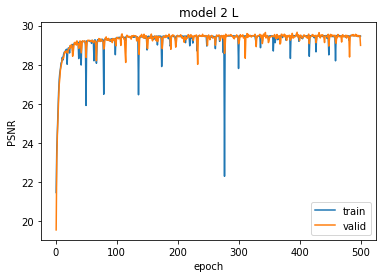

In [58]:
plt.plot(np.arange(1, nb_epoch+1, 1), history.history['val_PSNR'])
plt.plot(np.arange(1, nb_epoch+1, 1), history.history['PSNR'])
plt.title('model 2 L')
plt.ylabel('PSNR')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.savefig("model 2-3/PSNR model 2-3.png")
plt.show()

In [20]:
layer = model.layers[0]
weights = layer.get_weights()
w = weights[0]
f = np.zeros((w.shape[3],w.shape[0], w.shape[1], w.shape[2]))
for k in range(n1):
    filter2 = Image.new('L', (w.shape[0],w.shape[1]))
    p1 = filter2.load()
    for i in range(w.shape[0]):
        for j in range(w.shape[1]):
            p1[i,j] = int(w[i][j][0][k]*255)
            f[k,i,j,0] = int(w[i][j][0][k]*255)
    filter2.save('model 2-3/filter '+str(k)+'.png')

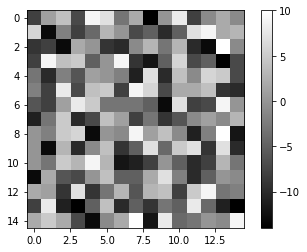

In [37]:
plt.imshow(f[0].squeeze(), cmap='gray')
plt.colorbar()
plt.savefig("model 2-3/filterplt 1.png")
plt.show()

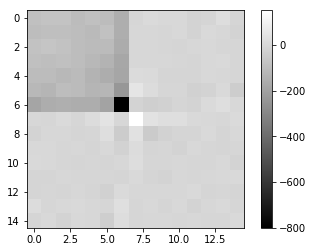

In [38]:
plt.imshow(f[1].squeeze(), cmap='gray')
plt.colorbar()
plt.savefig("model 2-3/filterplt 2.png")
plt.show()

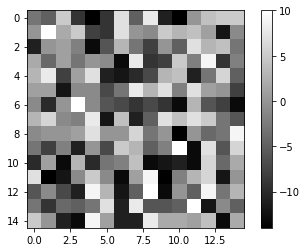

In [39]:
plt.imshow(f[2].squeeze(), cmap='gray')
plt.colorbar()
plt.savefig("model 2-3/filterplt 3.png")
plt.show()

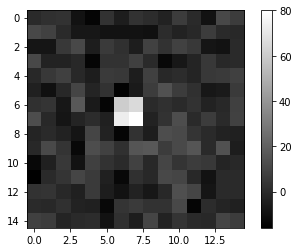

In [40]:
plt.imshow(f[3].squeeze(), cmap='gray')
plt.colorbar()
plt.savefig("model 2-3/filterplt 4.png")
plt.show()

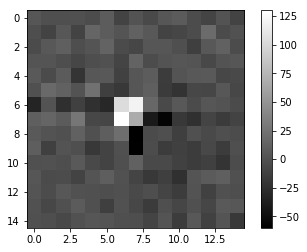

In [41]:
plt.imshow(f[4].squeeze(), cmap='gray')
plt.colorbar()
plt.savefig("model 2-3/filterplt 5.png")
plt.show()

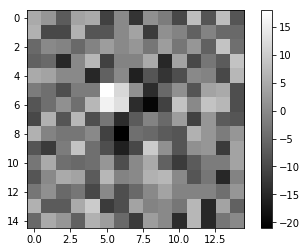

In [42]:
plt.imshow(f[5].squeeze(), cmap='gray')
plt.colorbar()
plt.savefig("model 2-3/filterplt 6.png")
plt.show()

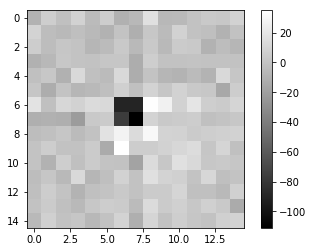

In [43]:
plt.imshow(f[6].squeeze(), cmap='gray')
plt.colorbar()
plt.savefig("model 2-3/filterplt 7.png")
plt.show()

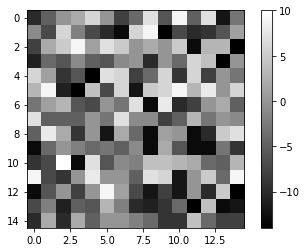

In [44]:
plt.imshow(f[7].squeeze(), cmap='gray')
plt.colorbar()
plt.savefig("model 2-3/filterplt 8.png")
plt.show()

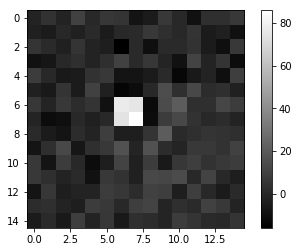

In [45]:
plt.imshow(f[8].squeeze(), cmap='gray')
plt.colorbar()
plt.savefig("model 2-3/filterplt 9.png")
plt.show()

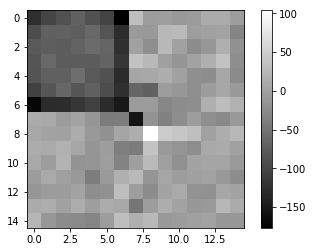

In [46]:
plt.imshow(f[9].squeeze(), cmap='gray')
plt.colorbar()
plt.savefig("model 2-3/filterplt 10.png")
plt.show()

In [53]:
model = load_model('model 2-3/model 2-3.h5', custom_objects={'PSNR': PSNR}) #если нужно выкачать модель

In [54]:
prediction = model.predict(in_test)
prediction5 = model.predict(in_test5)
prediction14 = model.predict(in_test14)

In [55]:
threecompare(in_test[0], out_test[0], prediction[0])

Original image
SSIM: 1.00

Bicubic image
SSIM: 0.93

Bicubic with laplasian image
SSIM: 0.92

Produced image
SSIM: 0.97


In [51]:
print('Результаты для всей тестовой выборки')
results(in_test, out_test, prediction, img_rows, img_cols, 'all')

print('\n'+'Результаты для тестовой выборки Set5')
results(in_test5, out_test5, prediction5, img_rows, img_cols, 'set5')

print('\n'+'Результаты для тестовой выборки Set14')
results(in_test14, out_test14, prediction14, img_rows, img_cols, 'set14')

Результаты для всей тестовой выборки
Bicubic PSNR: 27.6965971733
Laplasian PSNR: 27.0938131465
Model PSNR: 30.3463316166

Результаты для тестовой выборки Set5
Bicubic PSNR: 31.3020557059
Laplasian PSNR: 30.4734484203
Model PSNR: 34.7791565302

Результаты для тестовой выборки Set14
Bicubic PSNR: 27.1266165964
Laplasian PSNR: 26.5595325701
Model PSNR: 29.6455541486


In [52]:
print('Результаты для всей тестовой выборки')
ressim(in_test, out_test, prediction, img_rows, img_cols)

print('\n'+'Результаты для тестовой выборки Set5')
ressim(in_test5, out_test5, prediction5, img_rows, img_cols)

print('\n'+'Результаты для тестовой выборки Set14')
ressim(in_test14, out_test14, prediction14, img_rows, img_cols)

Результаты для всей тестовой выборки
Bicubic SSIM: 0.808942521008
Laplasian SSIM: 0.796779933914
Model SSIM: 0.86001802212

Результаты для тестовой выборки Set5
Bicubic SSIM: 0.891099641769
Laplasian SSIM: 0.876578923455
Model SSIM: 0.931971989827

Результаты для тестовой выборки Set14
Bicubic SSIM: 0.79595444677
Laplasian SSIM: 0.784164652479
Model SSIM: 0.848642946343
